### Exploratory Data Analysis of Group Psychotherapy Transcripts

- Joel Stremmel
- 04-17-23

##### About

This notebook explores group psychotherapy transcripts and survey data provided by Martin Kivlighan on 03-31-23.  It describes:

- The survey response scores per session per participant
- The total number and distribution of words per session
- The number of words spoken by each speaker across sessions
- The number of words per speaker per session
- A heatmatrix of speaker mentions by other speakers
- The number of utterances/speaking turns per speaker per session
- The average sentiment per speaker per session normalized by the utterance lengths for Ekman's 6 basic emotions using a [pretrained sentiment classifier](https://huggingface.co/j-hartmann/emotion-english-roberta-large).  We will likely want to look at variation in other measures over the sessions, but these sentiment scores stand-in for those measures for now and illustrate one way of tracking progress.

##### Next Steps

There are many ways to proceed.  The intention of this notebook is to get a feel for the data and some possible directions.  Next steps should be driven by the clinical investigators involved in this research.  A few ideas from the NLP-side include:

- Fitting deep topic models to identify word clusters
- Predicting specific coded measures such as group cohesion, therapist empathy, or positive clinical outcomes and using a method like the [Masked Sampling Procedure](https://proceedings.mlr.press/v193/stremmel22a/stremmel22a.pdf) to extract the sentences predictive of these measures.
- Experimenting with novel ways to represent multiple speakers in the classifiers used to predict the above measures.  Naive approaches would represent a given participants text indepedent of utterances from other speakers, which may be very useful and worth doing in a first pass.  However, capturing context from other participants would enhance the analysis and presents opportunities for novel NLP approaches.

##### Imports

In [1]:
import os
import re
import glob
import torch
import statistics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from pdfminer.high_level import extract_text
from transformers import AutoTokenizer, pipeline

##### Set Parameters

In [2]:
# Set sequence lengths for distribution plot and sentiment model
dist_max_seq_len = 32768
sent_max_seq_len = 512

# Set model/tokenizer paths
dist_tokenizer_path = "allenai/longformer-base-4096"
sent_model_path = "j-hartmann/emotion-english-roberta-large"

# Define data directory
pdf_dir = "./data/session_transcripts_iteration_2"

# Define survey data path
survey_path = "./data/WDS_Session_Survey_April_13_2023_17.07_ONLY Iteration2.xlsx"

# Group leaders
leaders = [
    "Hannah Norling (she/her)",
    "Devin Kelly (she/her/hers)",
    "Lisa Brownstone (She/Her)",
]

# Define session participants
participants = {
    "Betty_2": 8,
    "Martha_2": 9,
    "Tanya_2": 16,
    "Bonnie_2": 14,
    "Sharon_2": 10,
    "Cecilia_2": 11,
    "Maya_2": 17,
    "Addison_2": 12,
    "Penny_2": 15,
    "Gemma_2": 13,
}

# Define speakers as the combined set of leaders and participants
speakers = leaders + list(participants.keys())

# Define emotions used in sentiment model
emotions = ["neutral", "sadness", "surprise", "joy", "fear", "disgust", "anger"]

# Plot size
matplotlib.rcParams["figure.figsize"] = (8, 8)

# Set the default color cycle
CB_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
    "#000000",
    "#8DA0CB",
    "#A6D854",
    "#E5C494",
]
assert len(CB_color_cycle) == len(
    speakers
), "Number of colors should equal number of speakers."
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=CB_color_cycle)

##### Load Survey Data

In [3]:
df = pd.read_excel(survey_path)

##### Define Score and Text Dataframes from Surveys

In [4]:
score_df = df[
    [
        "Session",
        "ID",
        "GEM",
        "GSRS1",
        "GSRS2",
        "GSRS3",
        "GSRS4",
        "GSRS_Tot",
        "Q9_1",
        "Q9_2",
    ]
]

text_df = df[["Session", "ID", "Q5", "Q6", "Q7"]]

##### Sort Score Dataframe

In [5]:
score_df = score_df.sort_values("Session")

##### Plot Scores per Participant per Session

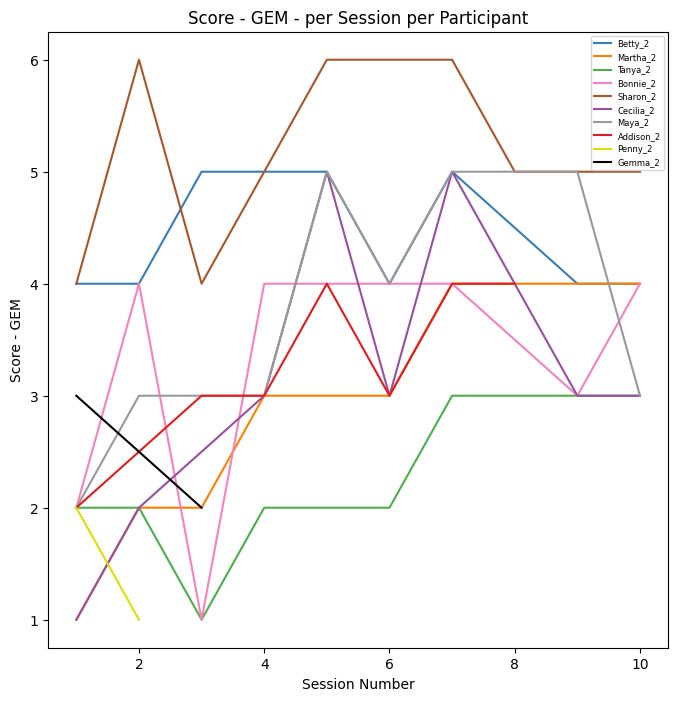

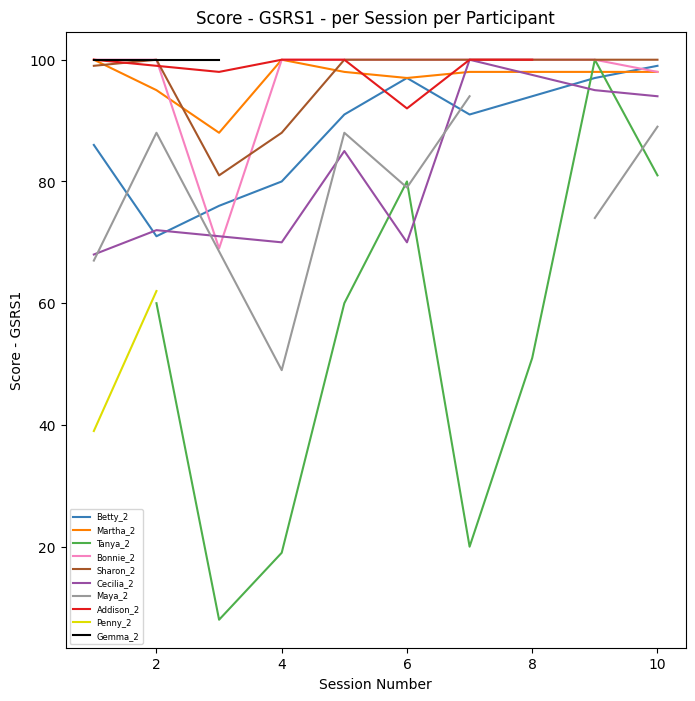

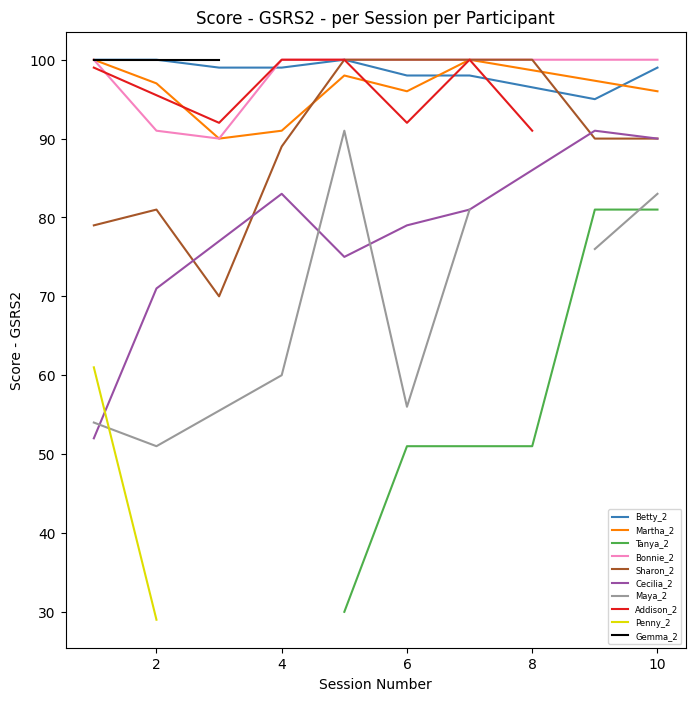

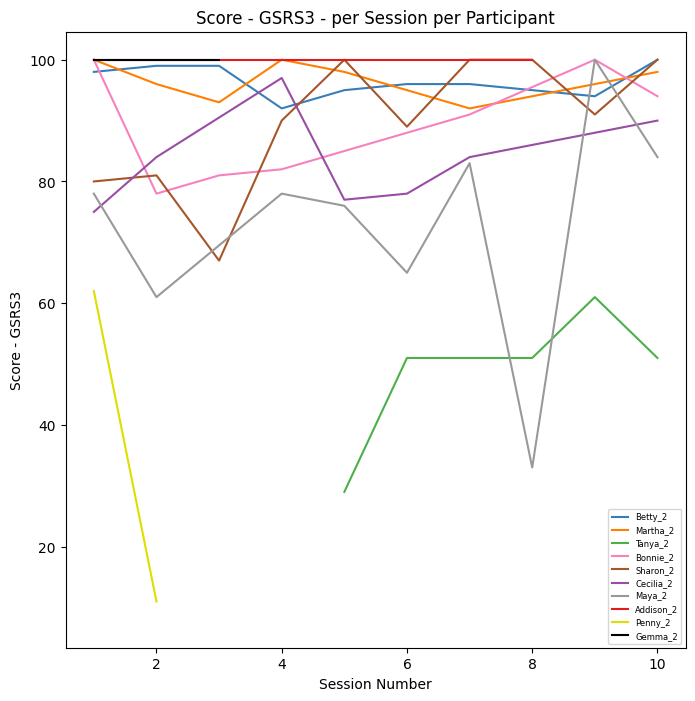

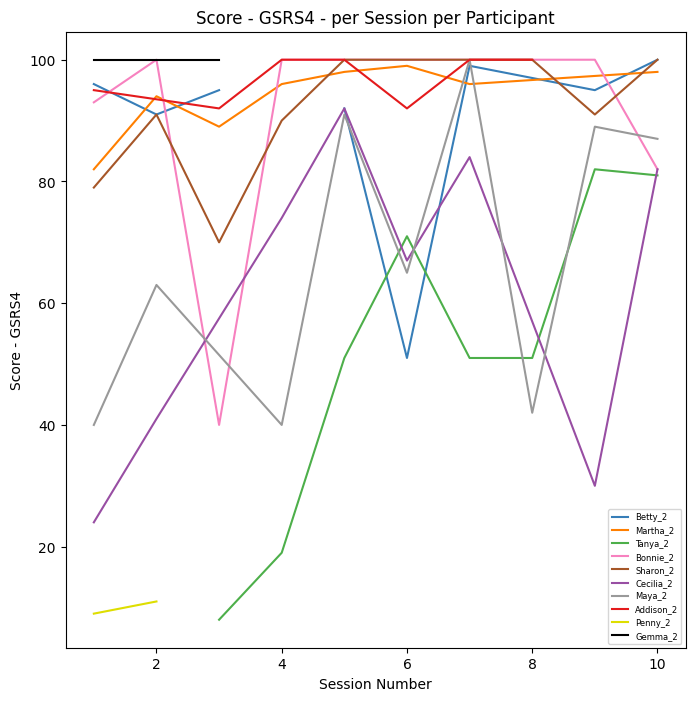

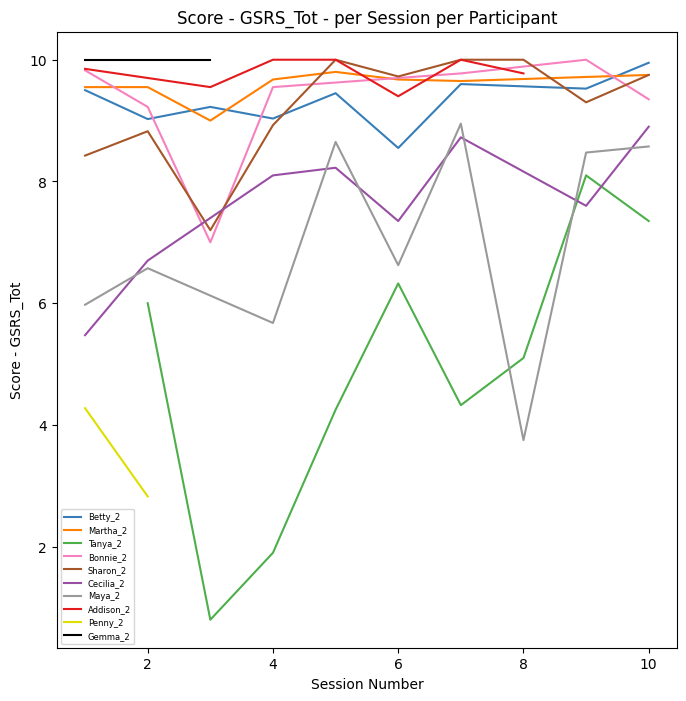

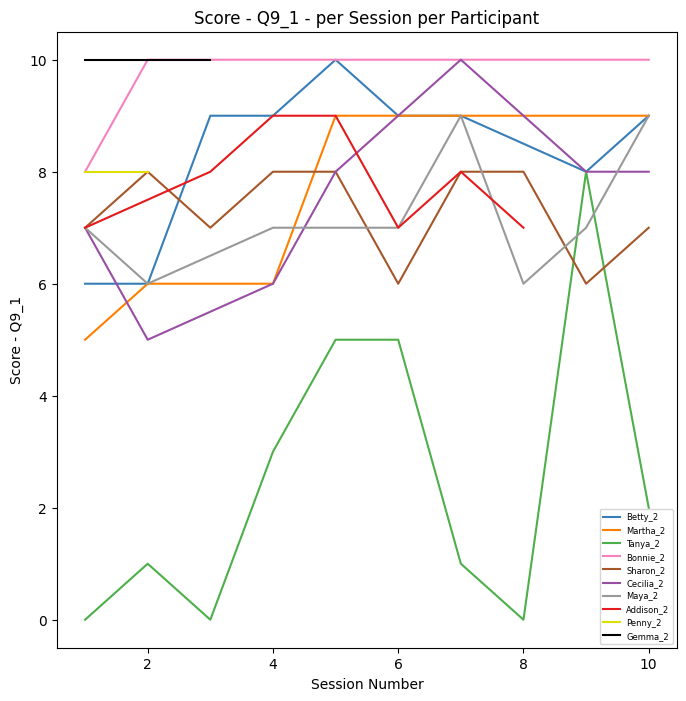

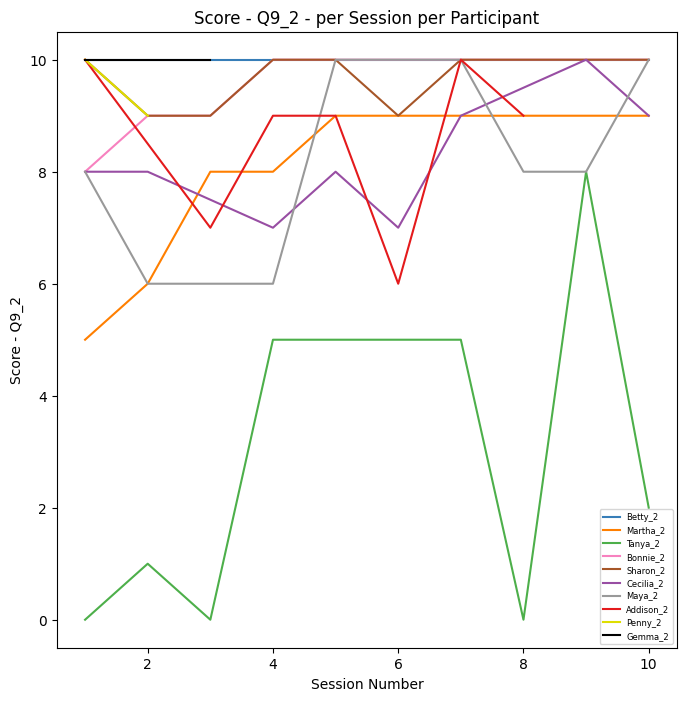

In [6]:
# Check that score dataframe is sorted by session
sessions = score_df["Session"].tolist()
assert_msg = "Expected score dataframe to be sorted by session."
assert all(sessions[i] <= sessions[i + 1] for i in range(len(sessions) - 1)), assert_msg

# Knowing the sessions are ordered, filter for each session ID for each participant
# And plot the score per session per participant for all scores
scores = [col for col in score_df.columns if col not in ["Session", "ID"]]
for score in scores:
    fig, ax = plt.subplots()
    for participant, participant_id in participants.items():
        x = score_df[score_df["ID"] == participant_id]["Session"].tolist()
        y = score_df[score_df["ID"] == participant_id][score].tolist()
        ax.plot(x, y, label=participant)

    # Set plot title and axis labels
    ax.set_title(f"Score - {score} - per Session per Participant")
    ax.set_xlabel("Session Number")
    ax.set_ylabel(f"Score - {score}")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()

##### Load Tokenizers

In [7]:
dist_tokenizer = AutoTokenizer.from_pretrained(dist_tokenizer_path)
sent_tokenizer = AutoTokenizer.from_pretrained(sent_model_path)

##### Load Sentiment Model

In [8]:
sent_pipeline = pipeline(
    "text-classification",
    model=sent_model_path,
    return_all_scores=True,
    truncation=True,
    max_length=sent_max_seq_len,
    top_k=None,
)

##### Collect PDFs of Transcripts

In [9]:
pdf_files = glob.glob(os.path.join(pdf_dir, "*.pdf"))

##### Extract PDF Text and Count Words

./data/session_transcripts_iteration_2/WDS2.7 Transcript.pdf - Number of words: 6450 | Number of subwords: 9753
./data/session_transcripts_iteration_2/WDS2.3 Transcript.pdf - Number of words: 6637 | Number of subwords: 16477
./data/session_transcripts_iteration_2/WDS2.TEN Transcript.pdf - Number of words: 5445 | Number of subwords: 8445
./data/session_transcripts_iteration_2/WDS2.2 Transcript.pdf - Number of words: 6753 | Number of subwords: 16792
./data/session_transcripts_iteration_2/WDS2.9 Transcript.pdf - Number of words: 6743 | Number of subwords: 10499
./data/session_transcripts_iteration_2/WDS2.5 Transcript.pdf - Number of words: 6541 | Number of subwords: 10222
./data/session_transcripts_iteration_2/WDS2.8 Transcript.pdf - Number of words: 5266 | Number of subwords: 8349
./data/session_transcripts_iteration_2/WDS2.4 Transcript.pdf - Number of words: 6737 | Number of subwords: 10430
./data/session_transcripts_iteration_2/WDS2.1 Transcript.pdf - Number of words: 8219 | Number of 

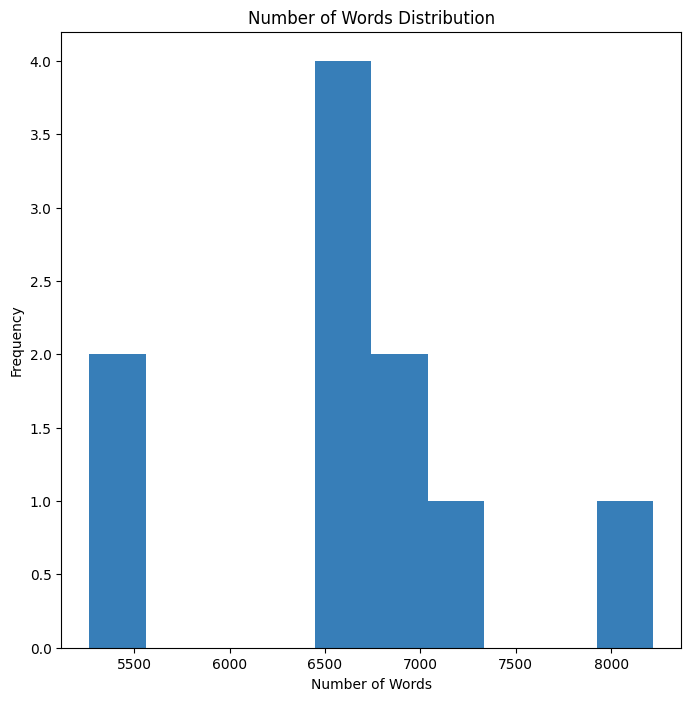

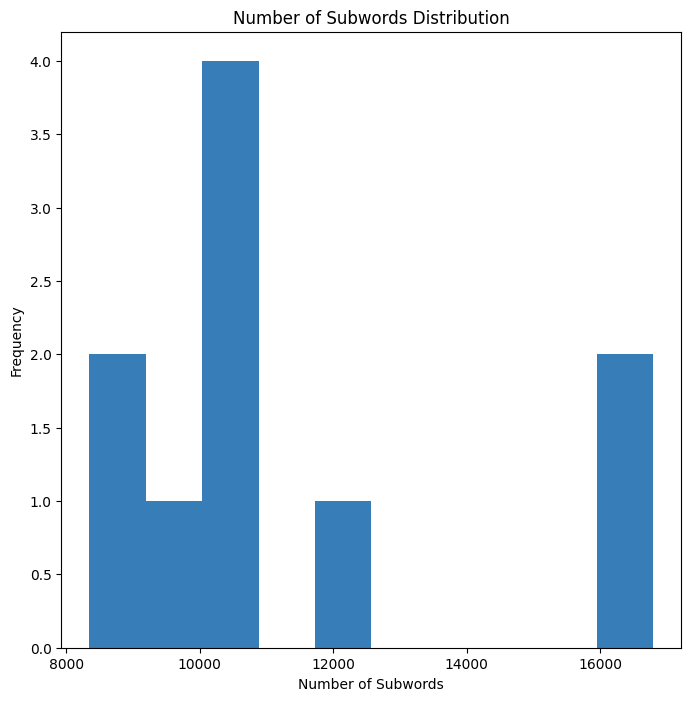

In [10]:
# Loop through each PDF file, convert to plain text, and count the number of words
num_words_list = []
num_subwords_list = []
for pdf_file in pdf_files:
    text = extract_text(pdf_file)
    num_words = len(text.split())
    num_words_list.append(num_words)

    tokenized_text = dist_tokenizer(
        text, padding=False, truncation=True, max_length=dist_max_seq_len
    )
    num_subwords = len(tokenized_text["input_ids"])
    num_subwords_list.append(num_subwords)
    print(
        f"{pdf_file} - Number of words: {num_words} | Number of subwords: {num_subwords}"
    )

# Calculate descriptive statistics
mean_num_words = statistics.mean(num_words_list)
std_num_words = statistics.stdev(num_words_list)
mean_num_subwords = statistics.mean(num_subwords_list)
std_num_subwords = statistics.stdev(num_subwords_list)

# Print descriptive statistics
print(f"\nNumber of documents: {len(num_words_list)}")
print(f"Mean number of words per document: {mean_num_words:.2f}")
print(f"Standard deviation of number of words per document: {std_num_words:.2f}")
print(f"Mean number of subwords per document: {mean_num_subwords:.2f}")
print(f"Standard deviation of number of subwords per document: {std_num_subwords:.2f}")

# Generate histogram of  sequence lengths for all documents
plt.hist(num_words_list, bins=10)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Number of Words Distribution")
plt.show()

plt.hist(num_subwords_list, bins=10)
plt.xlabel("Number of Subwords")
plt.ylabel("Frequency")
plt.title("Number of Subwords Distribution")
plt.show()

##### Define Function to Remove Lines

In [11]:
def should_remove(line):
    line = line.strip()
    if line.isdigit() or not line or (line.startswith("{") and line.endswith("}")):
        return True

##### Extract Text and Count Words per Speaker

In [12]:
# Save total word counts, speaker word counts, mentions of, and complete utterances
word_counts = {}
speaker_word_counts = {}
speaker_mentions_of = {
    speaker: {spoken_to: 0 for spoken_to in speakers} for speaker in speakers
}
speaker_utterances = {
    speaker: {num: [] for num in range(len(pdf_files))} for speaker in speakers
}

# Iterate through files to extract words
for i, file in enumerate(pdf_files):
    # Reset speaker counts for new file
    speaker_counts = {}

    # Reset current speaker
    current_speaker = None

    # Reset utterance
    utterance = ""

    # Extract text
    text = extract_text(file)

    # Iterate through text split on double new lines
    for line in text.split("\n"):
        # If the line is blank, keep going
        if not line:
            continue

        # Check if one of the speakers is speaking
        for speaker in speakers:
            if line.startswith(speaker + ":"):
                # If the current speaker is the same as this speaker, keep going
                if current_speaker == speaker:
                    break

                # Otherwise, we have a new speaker and we want to save the full utterance
                # from the previous speaker, set the new speaker, and reset the utterance
                # If the current speaker is None, it's our first iteration and there's
                # Nothing to save
                else:
                    if current_speaker is None:
                        assert utterance == "", "Expected utterance to be empty."
                    else:
                        speaker_utterances[current_speaker][i].append(utterance)
                    current_speaker = speaker
                    utterance = ""

        # If we have a current speaker, count the number of words in the line
        if current_speaker:
            # Handle empty lines, bracketted info, and page numbers
            if should_remove(line):
                continue

            # Remove the speaker name from the line
            # Split on any number of whitespaces to define the words in the line
            clean_line = line.replace(current_speaker + ":", "")

            # Identify mentions of other speakers
            for speaker in speakers:
                if f"[{speaker}]" in clean_line:
                    speaker_mentions_of[current_speaker][speaker] += 1

            # Get words
            words = clean_line.split()

            # Count the number of words in the line
            num_words = len(words)

            # Save the word counts
            if current_speaker in speaker_counts:
                speaker_counts[current_speaker] += num_words
            else:
                speaker_counts[current_speaker] = num_words

            # Add to the utterance which will contain words seperated only by single spaces
            utterance += " ".join(clean_line.split())

    # Track the total number of words spoken in the file by summing the words from each speaker
    word_counts[file] = sum(speaker_counts.values())

    # Track the total number of words spoken by each speaker across documents
    for speaker in speakers:
        if speaker in speaker_counts:
            if speaker in speaker_word_counts:
                speaker_word_counts[speaker] += speaker_counts[speaker]
            else:
                speaker_word_counts[speaker] = speaker_counts[speaker]

##### Compute and Display Descriptive Statistics

In [13]:
mean_num_words = statistics.mean(word_counts.values())
std_num_words = statistics.stdev(word_counts.values())

print(f"\nNumber of documents: {len(word_counts)}")
print(f"Mean number of words per document: {mean_num_words:.2f}")
print(f"Standard deviation of number of words per document: {std_num_words:.2f}")


Number of documents: 10
Mean number of words per document: 6349.20
Standard deviation of number of words per document: 816.61


##### Plot Word-Level Sequence Lengths
Note that because we strip text not directly associated with a speaker, the counts differ slightly from above.

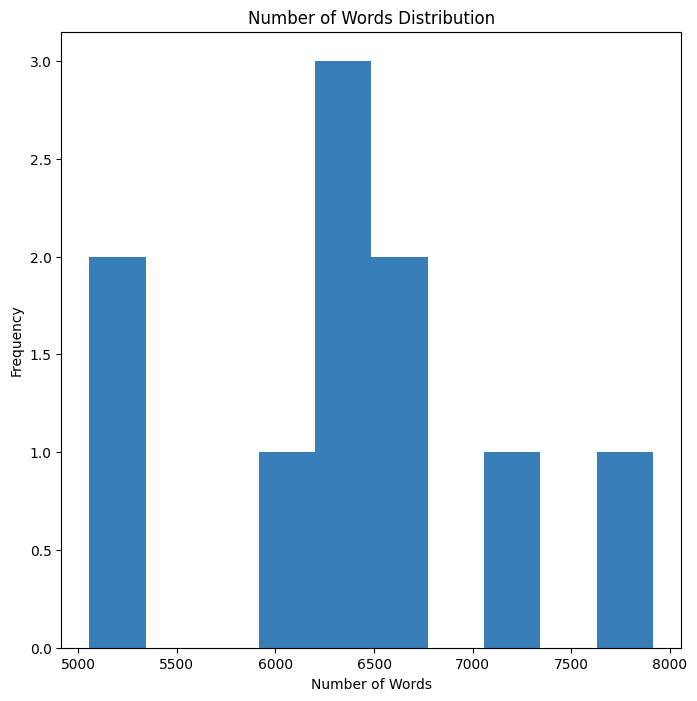

In [14]:
plt.hist(word_counts.values(), bins=10)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Number of Words Distribution")
plt.show()

##### Define Function to Differentiate between Participants and Leaders

In [15]:
def add_leader_tag(d, leaders):
    d_plot = {}
    for k, v in d.items():
        if k in leaders:
            d_plot[k + " - Leader"] = v
        else:
            d_plot[k] = v

    return d_plot

##### Plot Total Words Spoken per Speaker

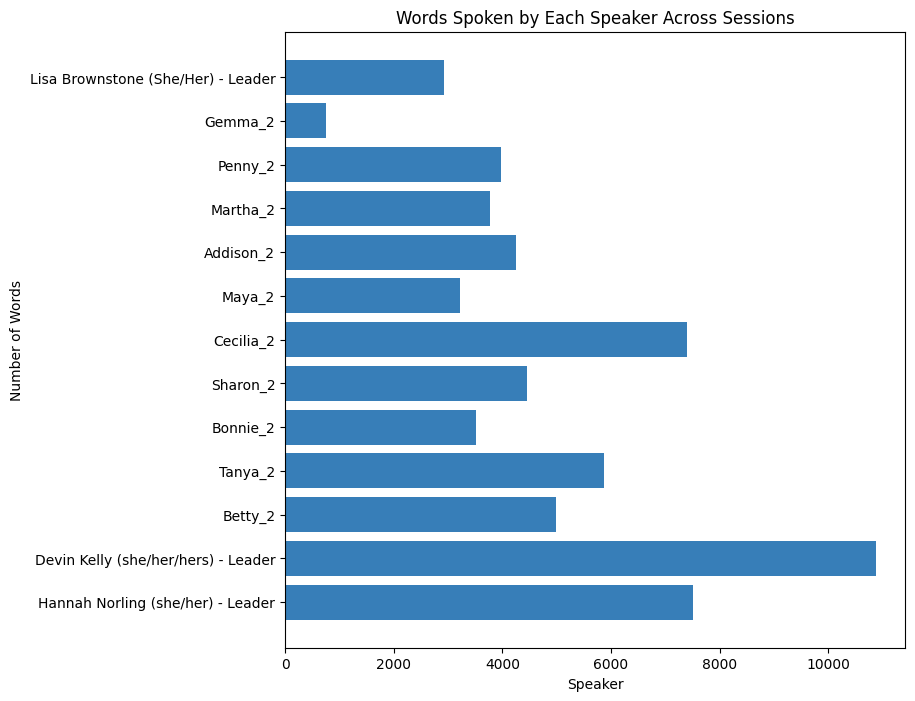

In [16]:
speaker_word_counts = add_leader_tag(speaker_word_counts, leaders)
plt.barh(list(speaker_word_counts.keys()), speaker_word_counts.values())
plt.title("Words Spoken by Each Speaker Across Sessions")
plt.xlabel("Speaker")
plt.ylabel("Number of Words")
plt.show()

##### View Speaker Mentions of Other Speakers

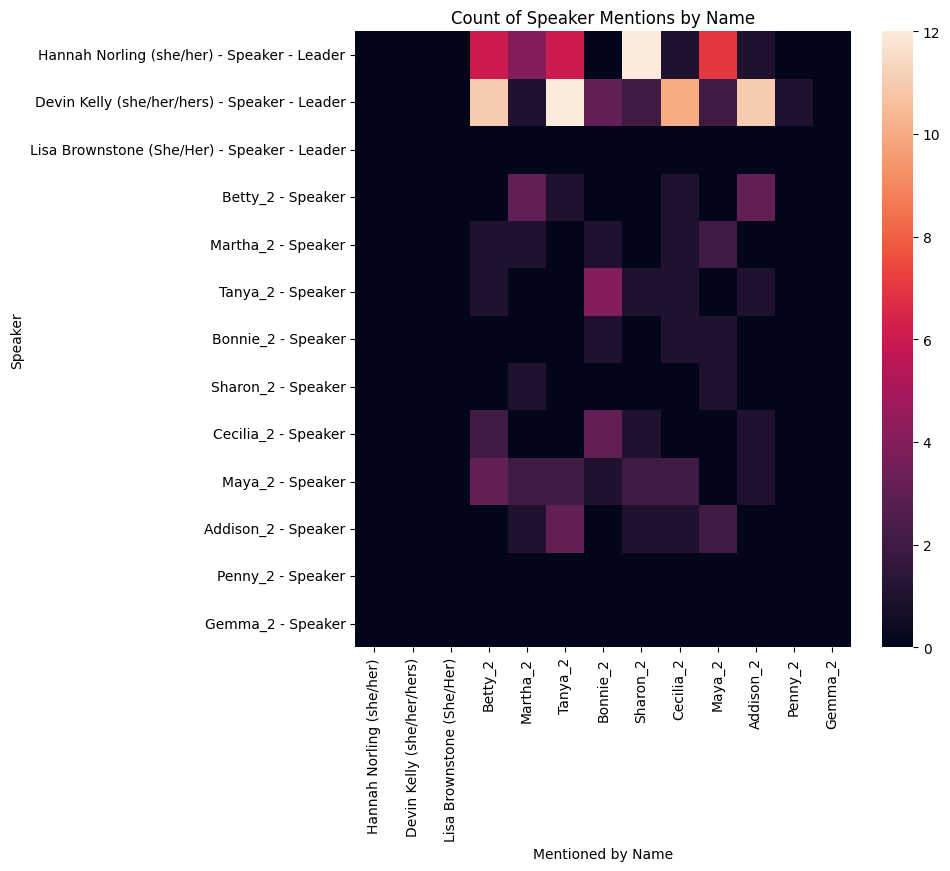

In [17]:
speaker_dict = {k + " - Speaker": v for k, v in speaker_mentions_of.items()}
speaker_dict = add_leader_tag(speaker_dict, [l + " - Speaker" for l in leaders])
speaker_matrix = pd.DataFrame(speaker_dict).T.fillna(0)
sb.heatmap(speaker_matrix)
plt.xlabel("Mentioned by Name")
plt.ylabel("Speaker")
plt.title("Count of Speaker Mentions by Name")
plt.show()

##### Plot the Number of Utterances from Each Speaker for Each Session

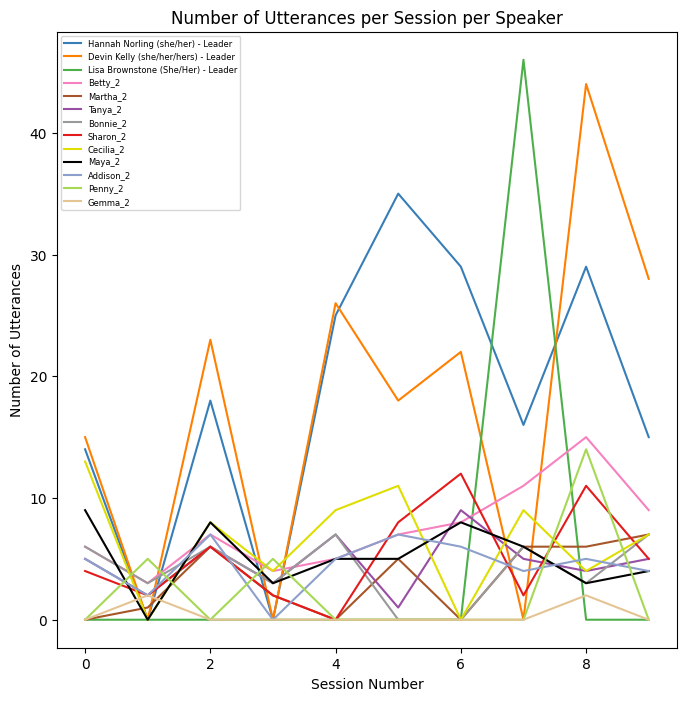

In [18]:
# Create plot
fig, ax = plt.subplots()
for key in speaker_utterances:
    x = list(speaker_utterances[key].keys())
    y = [len(speaker_utterances[key][i]) for i in x]

    if key in leaders:
        label = key + " - Leader"
    else:
        label = key

    ax.plot(x, y, label=label)

# Set plot title and axis labels
ax.set_title("Number of Utterances per Session per Speaker")
ax.set_xlabel("Session Number")
ax.set_ylabel("Number of Utterances")

# Set legend
ax.legend(fontsize=6, loc="best")

# Show plot
plt.show()

##### Plot Number of Words per Speaker per Session

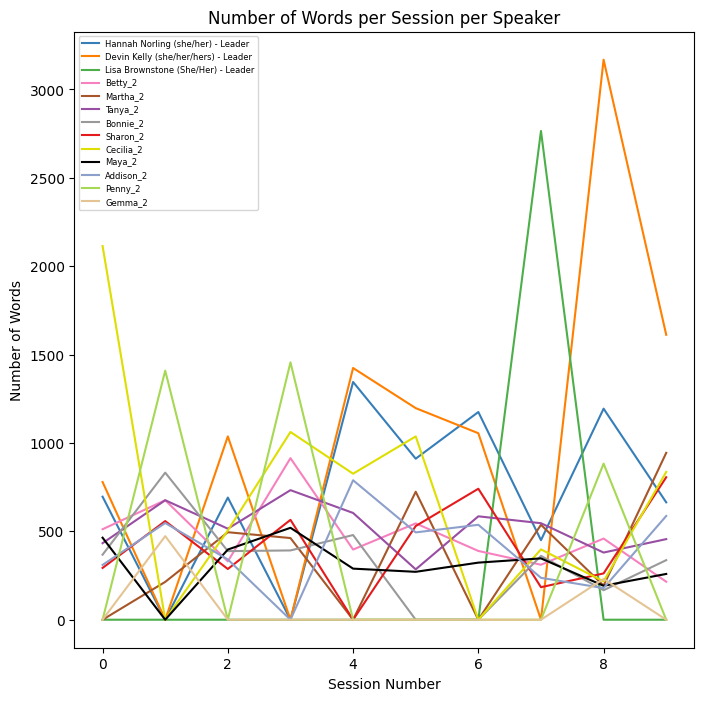

In [19]:
# Create plot
fig, ax = plt.subplots()
for key in speaker_utterances:
    x = list(speaker_utterances[key].keys())
    y = [
        sum([len(utterance.split()) for utterance in speaker_utterances[key][i]])
        for i in x
    ]

    if key in leaders:
        label = key + " - Leader"
    else:
        label = key

    ax.plot(x, y, label=label)

# Set plot title and axis labels
ax.set_title("Number of Words per Session per Speaker")
ax.set_xlabel("Session Number")
ax.set_ylabel("Number of Words")

# Set legend
ax.legend(fontsize=6, loc="best")

# Show plot
plt.show()

##### Compute Normalized Emotion Scores Over All Utterances in Each Session

In [20]:
xs = []
ys = []
for key in speaker_utterances:
    x = list(speaker_utterances[key].keys())
    y = {emotion: [] for emotion in emotions}

    for i in x:
        # Iterate through utterances to obtain emotion scores
        word_count = 0
        emotion_scores = {emotion: [] for emotion in emotions}
        for utterance in speaker_utterances[key][i]:
            # Compute utterance length in words
            utterance_length = len(utterance.split())
            word_count += utterance_length

            # Compute sentiment
            # To reduce runtime, run inference over batched utterances
            output = sent_pipeline(utterance)[0]

            # Save normalized emotion scores
            for d in output:
                # Compute the normalized emotion score
                emotion_scores[d["label"]].append(d["score"] * utterance_length)

        # Add the scaled emotion score for the emotion of interest
        for emotion in emotions:
            # Get the scores for the given emotion
            scores = emotion_scores[emotion]

            # Scale the scores
            if word_count == 0:
                scaled_score = 0
            else:
                scaled_score = sum(scores) / word_count

            # Save the scaled score
            y[emotion].append(scaled_score)

    xs.append(x)
    ys.append(y)

##### Define Function to Plot Trend for a Given Emotion

In [21]:
def plot_emotion_trend(emotion):
    # Create plot
    fig, ax = plt.subplots()

    # Iterate through sessions
    for key, x, y in zip(speaker_utterances, xs, ys):
        if key in leaders:
            label = key + " - Leader"
        else:
            label = key

        # Plot emotion scores for the session for the given participant
        ax.plot(x, y[emotion], label=label)

    # Set plot title and axis labels
    ax.set_title(f"Score for Emotion: {emotion}")
    ax.set_xlabel("Session Number")
    ax.set_ylabel("Session Emotion Score Normalized by Utterance Lengths")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()

##### Plot All Emotion Trends

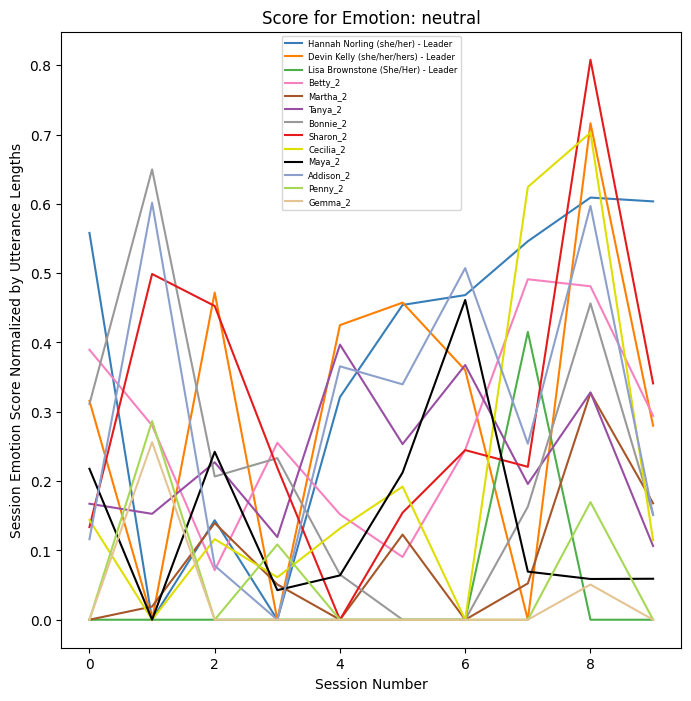

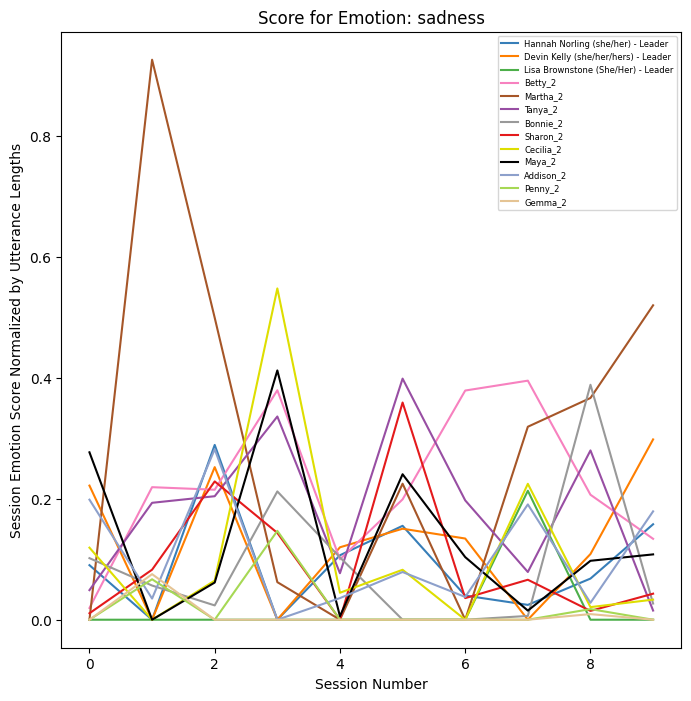

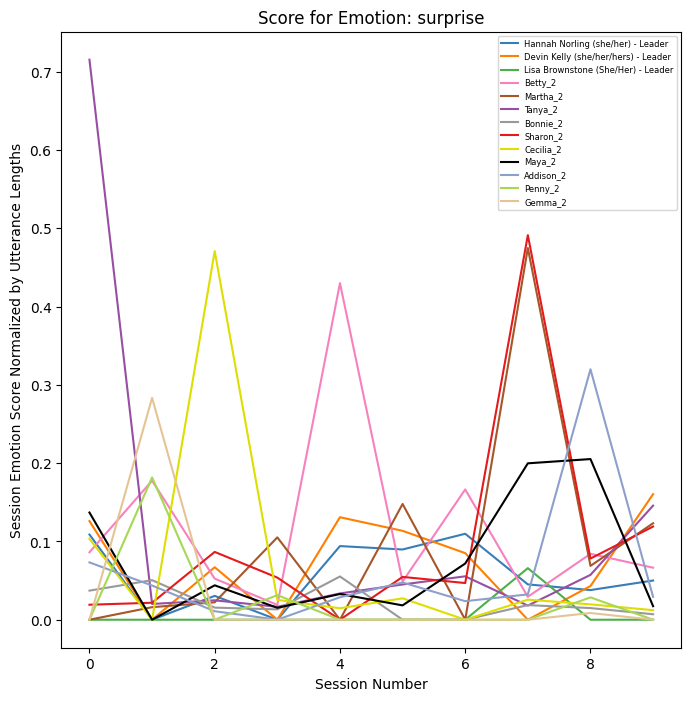

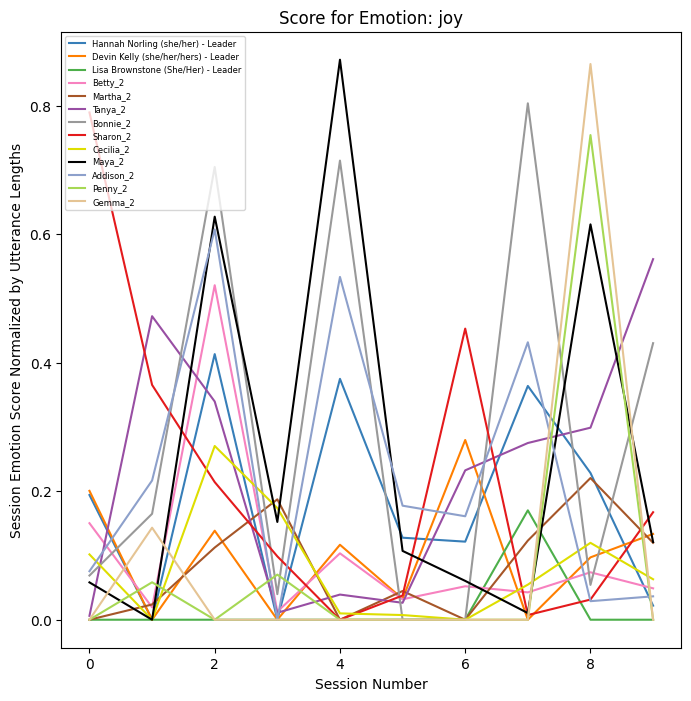

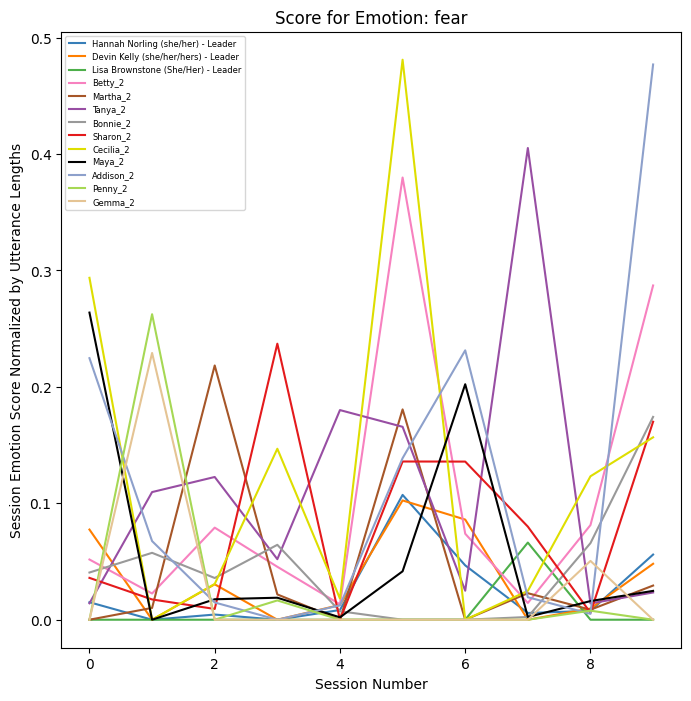

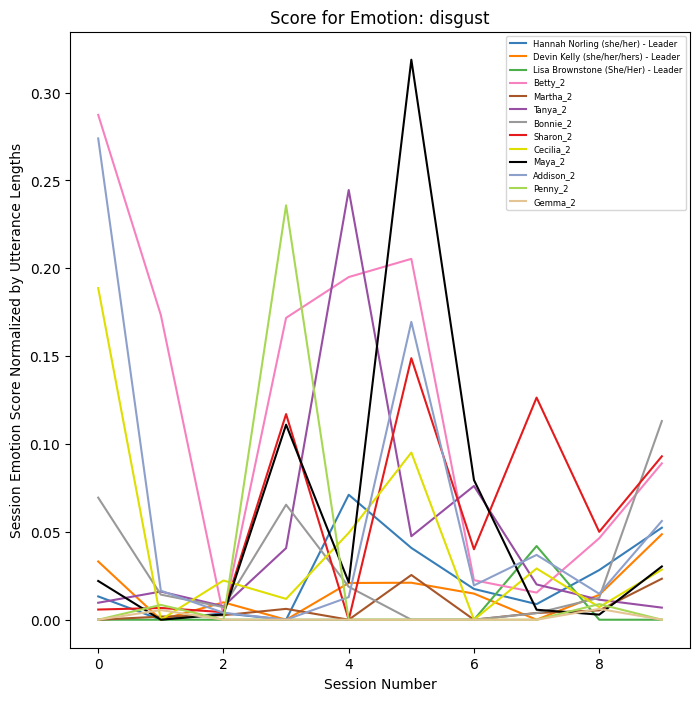

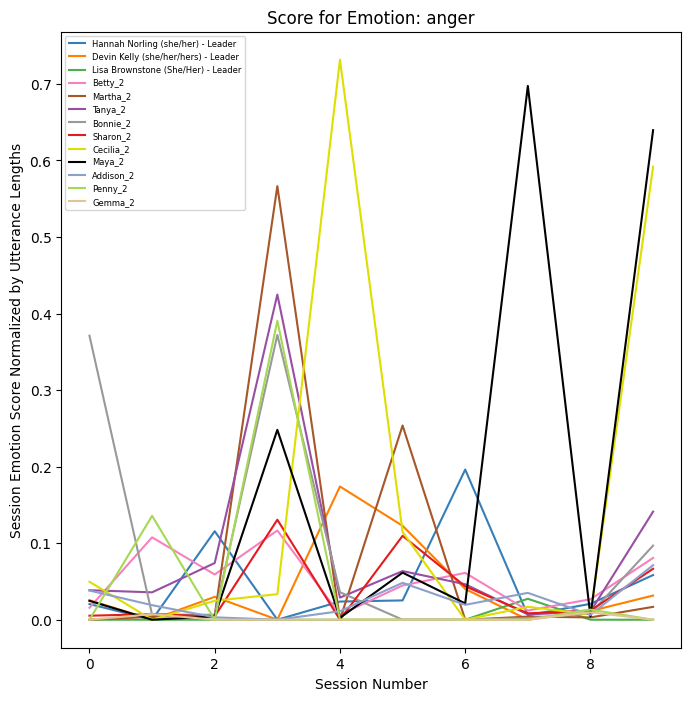

In [22]:
for emotion in emotions:
    plot_emotion_trend(emotion)